## Load and reduce galaxy catalog

The initial (NED Local Volume Sample) catalog is available at the following url: https://ned.ipac.caltech.edu/NED::LVS/

A reduced version for galaxies closer than 150 Mpc, with duplicate entries (within 5 arcsec) removed, is available in this folder: https://drive.google.com/drive/folders/1M0o6B6UKuB0DE3b9mooW9IulC_U0rGev?usp=drive_link

The BG field list, the selection of BGLT fields and the HECATE catalog restricted to galaxies closer than 180 Mpc are available in the same folder.

In [1]:
from astropy.table import Table
import pandas as pd
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, SkyOffsetFrame
import astropy.units as u
from astropy.wcs import WCS
import json
import requests
from PIL import Image
import urllib
from matplotlib.patches import Circle

use_hecate = 1
accurate_match = 0

datadir = "Downloads/Catalogs/"

In [2]:
lvs = Table.read(datadir+"LVS_150.fits")
hec = Table.read(datadir+"HECATE_180.fits")
hec['OBJNAME'].name = 'objname'
hec['RA'].name = 'ra'
hec['DEC'].name = 'dec'

# invert LVS and HECATE
if use_hecate:
    hec = Table.read(datadir+"LVS_150.fits")
    lvs = Table.read(datadir+"HECATE_180.fits")
    lvs = lvs[lvs['D']<150]
    lvs['RA'].name = 'ra'
    lvs['DEC'].name = 'dec'
    lvs['OBJNAME'].name = 'objname'
    hec['logM_HEC'] = np.log10(hec['Mstar'])
    hec['logSFR_HEC'] = np.log10(hec['SFR_hybrid'])
    lvs['Mstar'] = 10**lvs['logM_HEC']
    lvs['SFR_hybrid'] = 10**lvs['logSFR_HEC']
    sfr_missing = hec['SFR_hybrid'].mask
    hec['logSFR_HEC'][sfr_missing] = np.log10(hec['SFR_W4'][sfr_missing])

In [3]:
c1 = SkyCoord(lvs['ra'],lvs['dec'],frame='icrs',unit='deg')
c2 = SkyCoord(hec['ra'],hec['dec'],frame='icrs',unit='deg')

# Match LVS and HECATE
idx,d2d,d3d = c1.match_to_catalog_sky(c2)

# Matching radius = 5 arcsec
ind = d2d.arcsec<5
idxind = idx[ind]

print(np.sum(ind), "LVS galaxies have a match in HECATE")

114193 LVS galaxies have a match in HECATE


* For galaxies with no SFR_hybrid, use SFR_W4
* For galaxies with no SFR or stellar mass, use HECATE values

In [4]:
mstar_missing = lvs['Mstar'].mask
print(np.sum(mstar_missing),"LVS galaxies with no Mstar")

sfr_missing = lvs['SFR_hybrid'].mask

# For galaxies with no SFR_hybrid, use SFR_W4
if not(use_hecate):
    lvs['SFR_hybrid'][sfr_missing] = lvs['SFR_W4'][sfr_missing]

sfr_missing = lvs['SFR_hybrid'].mask
print(np.sum(sfr_missing),"LVS galaxies with no SFR")

# For galaxies with no SFR or stellar mass, use HECATE values
mstar_missing = np.logical_and(ind, mstar_missing)
sfr_missing = np.logical_and(ind, sfr_missing)

lvs['SFR_hybrid'][sfr_missing] = 10**hec['logSFR_HEC'][idx[sfr_missing]]
lvs['Mstar'][mstar_missing] = 10**hec['logM_HEC'][idx[mstar_missing]]

mstar_missing = lvs['Mstar'].mask
sfr_missing = lvs['SFR_hybrid'].mask
print(np.sum(mstar_missing),"LVS galaxies with no Mstar after HECATE completion")
print(np.sum(sfr_missing),"LVS galaxies with no SFR after HECATE completion")

47550 LVS galaxies with no Mstar
72532 LVS galaxies with no SFR
16381 LVS galaxies with no Mstar after HECATE completion
20692 LVS galaxies with no SFR after HECATE completion


## Keep only galaxies with valid SFR or Mstar and apply cuts

In [5]:
lvs = lvs[lvs['Mstar']>1e4]
lvs = lvs[lvs['SFR_hybrid']>0]
lvs['sSFR'] = lvs['SFR_hybrid']/lvs['Mstar']

print(len(lvs),"galaxies in clean sample")

115623 galaxies in clean sample


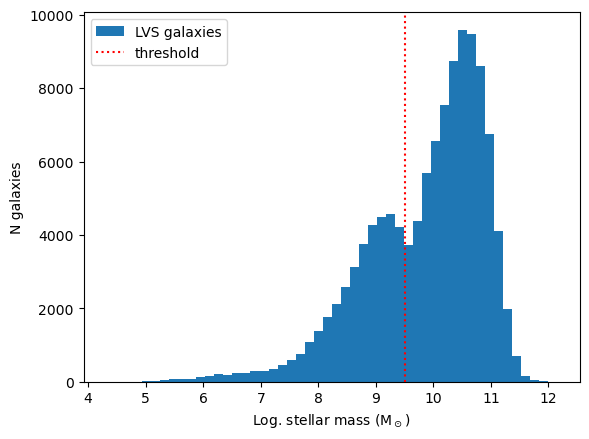

In [6]:
plt.hist(np.log10(lvs['Mstar']), bins=50, label='LVS galaxies')
plt.axvline(9.5, ls=':', color='r', label='threshold')
plt.xlabel("Log. stellar mass (M$_\odot$)")
plt.ylabel("N galaxies")
plt.legend()

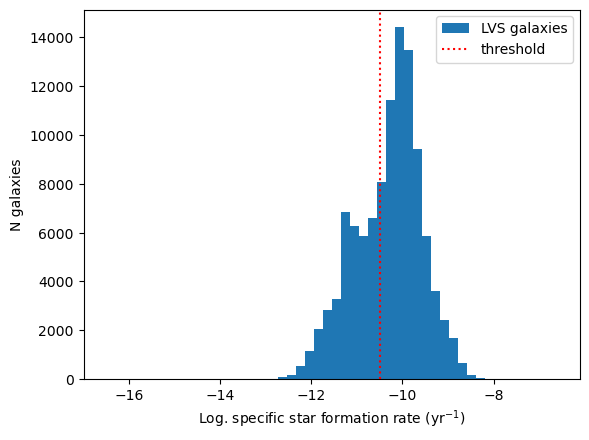

In [7]:
plt.hist(np.log10(lvs['sSFR']), bins=50, label='LVS galaxies')
plt.axvline(-10.5, ls=':', color='r', label='threshold')
plt.xlabel("Log. specific star formation rate (yr$^{-1}$)")
plt.ylabel("N galaxies")
plt.legend()

In [8]:
# apply cuts

lvs = lvs[np.logical_and(lvs['sSFR']>3e-11,lvs['Mstar']>3e9)]
lvs.write(datadir+"LVS_150_starforming.fits", overwrite=True)

print(len(lvs),"galaxies in massive starforming sample")

42821 galaxies in massive starforming sample


## Crossmatch with BlackGEM fields

The following function crossmatch the LVS galaxies positions to the coordinates of ML/BG fields.

A JSON file is generated to map each field to the corresponding LVS indexes

In [9]:
fields = pd.read_csv(datadir+"MLBG_FieldIDs_Oct2022.csv")
centers = SkyCoord(fields.ra.values*u.deg, fields.dec.values*u.deg, frame="icrs")
centers.transform_to(SkyOffsetFrame(origin=centers))

def coords2field(target, allfield = False):
    '''
    Returns the BlackGEM / MeerLICHT field IDS for a given position.

    Parameters
    ----------
    ra : float
        Right ascension of the position in degrees.
    dec : float
        Declination in degrees
        
    Returns
    -------
    fields : string or DataFrame
        The ID of the field(s) matching coordinates
    allfield: boolean
        Whether you want all fields matching coordinates or just one
    '''
    side = 1.64
    hside = side/2.
    
    
    target_centers = target.transform_to(SkyOffsetFrame(origin=centers))
    xi, eta = target_centers.lon, target_centers.lat

    contains_mask = (np.abs(xi) < hside*u.deg) * (np.abs(eta)< hside*u.deg)
        
    if allfield:
        return fields.iloc[contains_mask]['FieldID']
    else:
        return fields.iloc[contains_mask].iloc[0]['FieldID']


In [10]:
lvs = lvs[lvs['dec']<30]
coo = SkyCoord(lvs['ra'], lvs['dec'],frame='icrs',unit='deg')

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

if accurate_match:
    # more accurate (complete matching method) but longer
    
    galids = {}
    for i in tqdm(range(len(lvs))):
        fieldid_all = coords2field(coo[i],True)
        for j in range(len(fieldid_all)):
            f = int(fieldid_all.iloc[j])
            if f in galids.keys():
                galids[f].append(i)
                # new galaxy for the field, append to list
            else:
                galids[f] = [i]
                # first galaxy for the field, start a list



    with open(datadir+"BGfields.json", "w") as outfile: 
        json.dump(galids, outfile)

else:
    # missing some galaxies in regions with many overlapping fields, but ~6 times quicker
    
    # Best matching field for each galaxy
    idx,d2d,d3d = coo.match_to_catalog_sky(centers)
    circlematch1 = d2d.deg<1.64/2
    circlematch2 = np.logical_and(~circlematch1,d2d.deg<1.64*np.sqrt(2)/2)
    print("Circle and ring matches:", np.sum(circlematch1),np.sum(circlematch2))
    
    galids = {f:[] for f in fields['FieldID']}
    for i in tqdm(np.where(circlematch1)[0]):
        galids[fields.iloc[idx[i]]['FieldID']].append(i)

    # 2nd best match
    idx,d2d,d3d = coo.match_to_catalog_sky(centers, nthneighbor=2)
    circlematch_1 = d2d.deg<1.64/2
    circlematch_2 = np.logical_and(np.logical_and(~circlematch1,~circlematch_1),d2d.deg<1.64*np.sqrt(2)/2)
    print("Circle and ring matches (2nd neighbor):", np.sum(circlematch1),np.sum(circlematch_2))
    
    for i in tqdm(np.where(circlematch_1)[0]):
        galids[fields.iloc[idx[i]]['FieldID']].append(i)


    isquare = np.where(np.logical_or(circlematch2,circlematch_2))[0] # indexes to test against square match
    print("Number of remaining galaxies: %d/%d"%(len(isquare),len(lvs)))

    for i in tqdm(isquare):
        fieldid_all = coords2field(coo[i],True)
        for j in range(len(fieldid_all)):
            f = fieldid_all.iloc[j]
            galids[f].append(i)

    galids={k:v for (k,v) in galids.items() if len(v)>0}

    with open(datadir+"BGfields.json", "w") as outfile: 
        json.dump(galids, outfile, cls=NpEncoder)

Circle and ring matches: 27614 5009


100%|██████████████████████████████████████████████████████████████████████████| 27614/27614 [00:03<00:00, 7575.52it/s]


Circle and ring matches (2nd neighbor): 27614 4985


100%|██████████████████████████████████████████████████████████████████████████████| 896/896 [00:00<00:00, 7692.11it/s]


Number of remaining galaxies: 5009/32623


100%|██████████████████████████████████████████████████████████████████████████████| 5009/5009 [02:12<00:00, 37.95it/s]


In [11]:
galids={k:v for (k,v) in galids.items() if len(v)>0}
print(len(galids.keys()))
print([(k,galids2[k][0],lvs[galids2[k][0]]['R1']) for k in galids2.keys() if not(k in galids.keys())])

with open(datadir+"BGfields.json", "w") as outfile: 
    json.dump(galids, outfile, cls=NpEncoder)

9258


NameError: name 'galids2' is not defined

In [12]:
lvs[1785]

<Row index=1785>
objname     ra        dec       R1      R2      PA      T      E_T      D      E_D   DMETHOD    BT          Babs        ML_RATIO  logSFR_HEC  FLAG_SFR_HEC  logM_HEC  METAL  FLAG_METAL     Mstar     SFR_hybrid      sSFR    
           deg        deg     arcmin  arcmin   deg                     Mpc     Mpc             mag                               log(Msol/yr)              log(Msol)                                                          
bytes30  float64    float64  float32 float32 float32 float32 float32 float64 float32  bytes2 float32      float64       float32    float32       bytes2     float32  float32   int16       float32     float32      float32   
------- ---------- --------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------------------ -------- ------------ ------------ --------- ------- ---------- ------------- ---------- -------------
NGC3344 160.879791 24.922259   3.349   3.349     0.0     4.0     0.3  9.7662   0.687       N  10.501 -19.44762766497456       --       -0.125           RT   10.2354      --         -1 17194922000.0  0.7498942 4.3611375e-11

In [13]:
fields = pd.read_csv(datadir+"MLBG_FieldIDs_Oct2022.csv")

# Rough match to get total stellar mass - speeds up computation (due to large catalog)
lvs_all = Table.read(datadir+"LVS_150.fits")
if use_hecate:
    lvs_all = Table.read(datadir+"HECATE_180.fits")
    lvs_all = lvs_all[lvs_all['D']<150]
    lvs_all['RA'].name = 'ra'
    lvs_all['DEC'].name = 'dec'
    lvs_all['Mstar'] = 10**lvs_all['logM_HEC']

c1 = SkyCoord(lvs_all['ra'],lvs_all['dec'],frame='icrs',unit='deg')
c2 = SkyCoord(fields['ra'],fields['dec'],frame='icrs',unit='deg')
# Match LVS and BG fields
idx,d2d,d3d = c1.match_to_catalog_sky(c2)
sep_constraint = d2d.deg<1.64/2
print("matched LVS and BG fields")
fields['mtot_all'] = np.zeros(len(fields))
for i in tqdm(np.where(sep_constraint)[0]):
    fields['mtot_all'][idx[i]] += np.nansum([lvs_all[i]['Mstar']])


matched LVS and BG fields


  0%|                                                                                       | 0/110114 [00:00<?, ?it/s]C:\Users\hgtra\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:96: UserWarning: Warning: converting a masked element to nan.
  a = np.asanyarray(a)
C:\Users\hgtra\AppData\Local\Temp\ipykernel_11012\184193342.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fields['mtot_all'][idx[i]] += np.nansum([lvs_all[i]['Mstar']])
100%|████████████████████████████████████████████████████████████████████████| 110114/110114 [00:54<00:00, 2019.34it/s]


In [31]:

# Rough match to get total stellar mass - speed up computation (due to large catalog)
ztf = Table.read(datadir+"ZTF_BTS_18062024_unidec.csv")
cztf = SkyCoord(ztf['RA'],ztf['Dec'],frame='icrs',unit=[u.hourangle,u.deg])
c2 = SkyCoord(fields['ra'],fields['dec'],frame='icrs',unit='deg')
# Match ZTF and BG fields
idx,d2d,d3d = cztf.match_to_catalog_sky(c2)
sep_constraint = d2d.deg<1.64/2
print("matched ZTF and BG fields")
fields['nztf'] = np.zeros(len(fields)).astype(int)
for i in tqdm(np.where(sep_constraint)[0]):
    fields['nztf'][idx[i]] += 1

# Rough match to get total stellar mass - speed up computation (due to large catalog)
tns = Table.read(datadir+"tns_public_objects_until_20240528.csv")
tns = tns[np.logical_and(tns['reporting_group']!="GaiaAlerts",tns['discoverymag']<19.5)]
print("TNS sample length:",len(tns))
# next step: simulate uniform declination coverage
# (discoverymag<18. || RANDOM<2/(5+3*sin(degreesToRadians(declination))))
tns = tns[np.logical_or(tns['discoverymag']<18,np.random.random(len(tns))<3/(5+3*np.sin(tns['declination']*np.pi/180)))]
print("TNS unidec sample length:",len(tns))

ctns = SkyCoord(tns['ra'],tns['declination'],frame='icrs',unit='deg')
c2 = SkyCoord(fields['ra'],fields['dec'],frame='icrs',unit='deg')
# Match TNS and BG fields
idx,d2d,d3d = ctns.match_to_catalog_sky(c2)
sep_constraint = d2d.deg<1.64/2
print("matched TNS and BG fields")
fields['ntns'] = np.zeros(len(fields)).astype(int)
for i in tqdm(np.where(sep_constraint)[0]):
    fields['ntns'][idx[i]] += 1

    
    
with open(datadir+'BGfields.json') as json_file:
    galids = json.load(json_file)

ngal =  np.zeros(len(fields)).astype(int) # number of starforming massive LVS galaxies per field
mstar = np.zeros(len(fields)) # stellar mass from starforming massive LVS galaxies
sfrs =  np.zeros(len(fields)) # star formation rate from starforming massive LVS galaxies
lum = np.zeros(len(fields)) # apparent luminosity
    
for i in tqdm(range(len(mstar))):
    f = str(fields['FieldID'][i])
    if f in galids.keys():
        mstar[i] = np.nansum(lvs['Mstar'][galids[f],])
        sfrs[i] = np.nansum(lvs['SFR_hybrid'][galids[f],])
        if use_hecate:
            lum[i] = np.nansum(10**(-lvs['BT'][galids[f],]/2.5))
        else:
            lum[i] = np.nansum(10**(-lvs['m_W1'][galids[f],]/2.5))
        ngal[i] = len(galids[f])
        
fields['mtot'] = mstar
fields['sfrtot'] = sfrs
fields['ngal'] = ngal
fields['lum'] = lum

bglt_orig = pd.read_csv(datadir+"BGLT2_FieldIDs.dat") # original BGLT fields
i_orig = np.isin(fields['FieldID'],bglt_orig['col1'])
fields['BGLT_orig'] =  i_orig

matched ZTF and BG fields


  0%|                                                                                         | 0/6230 [00:00<?, ?it/s]C:\Users\hgtra\AppData\Local\Temp\ipykernel_11012\735764955.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fields['nztf'][idx[i]] += 1
100%|████████████████████████████████████████████████████████████████████████████| 6230/6230 [00:02<00:00, 2618.79it/s]


TNS sample length: 41043
TNS unidec sample length: 27963
matched TNS and BG fields


  0%|                                                                                        | 0/22634 [00:00<?, ?it/s]C:\Users\hgtra\AppData\Local\Temp\ipykernel_11012\735764955.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fields['ntns'][idx[i]] += 1
  0%|                                                                                        | 0/16080 [00:00<?, ?it/s]C:\Users\hgtra\AppData\Local\Temp\ipykernel_11012\735764955.py:48: UserWarning: Warning: converting a masked element to nan.
  lum[i] = np.nansum(10**(-lvs['BT'][galids[f],]/2.5))
  0%|▎                                                                             | 77/16080 [00:00<00:21, 760.30it/s]C:\Users\hgtra\AppData\Local\Temp\ipykernel_11012\735764955.py:46: UserWarning: Warning: converting a masked element to nan.
  sfrs[i] 

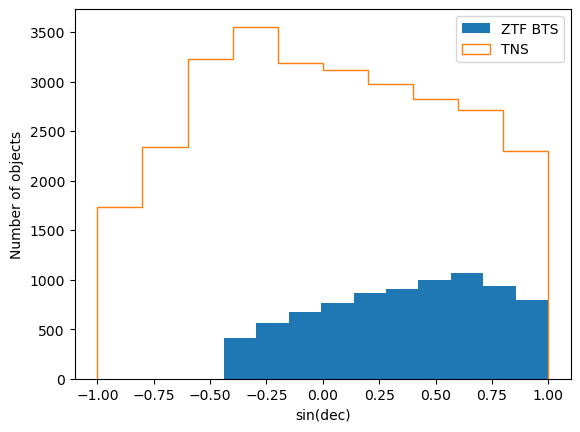

In [32]:
plt.hist(np.sin(cztf.icrs.dec.deg*np.pi/180),label="ZTF BTS")
plt.hist(np.sin(tns['declination']*np.pi/180),label="TNS",histtype='step')
plt.xlabel("sin(dec)")
plt.ylabel("Number of objects")
plt.legend()

In [33]:
#Southern sky
isouth = fields['dec']<30
fields_south = fields.loc[isouth]

sfrs = sfrs[isouth]
mstar = mstar[isouth]
i_orig = i_orig[isouth]

In [34]:
ngal = ngal[isouth]

In [35]:
# Define threshold
#sfr_min = 50
#ind = sfrs>sfr_min
ngal_min = 16
ind = np.logical_or(fields_south['ntns']>5,fields_south['mtot']>1e12)
fields_south.loc[:,'selected'] = ind

print(np.sum(ind), "fields are selected ")

fields_south.to_csv(datadir+"BGLT_fields_SFR_0624.csv")

204 fields are selected 


C:\Users\hgtra\AppData\Local\Temp\ipykernel_11012\306569863.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fields_south.loc[:,'selected'] = ind


C:\Users\hgtra\AppData\Local\Temp\ipykernel_11012\3579310084.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(mstar[ind]),bins=np.linspace(8,13,50),histtype='step',label="selected fields",lw=2)
C:\Users\hgtra\AppData\Local\Temp\ipykernel_11012\3579310084.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(mstar[i_orig]),bins=np.linspace(8,13,50),histtype='step',label="Paul's fields",color='C3',ls='--',lw=2)
C:\Users\hgtra\AppData\Local\Temp\ipykernel_11012\3579310084.py:14: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(sfrs[ind]),bins=np.linspace(-1.5,4,80),histtype='step',label='selected',lw=2)
C:\Users\hgtra\AppData\Local\Temp\ipykernel_11012\3579310084.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(sfrs[i_orig]),bins=np.linspace(-1.5,4,80),histtype='step',label="Paul's fields",color='C3',ls='--',lw=2)


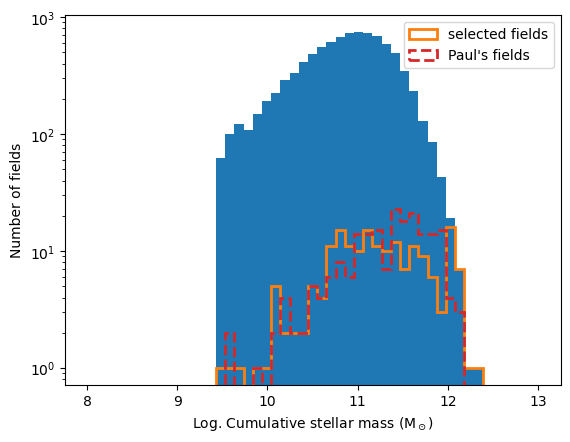

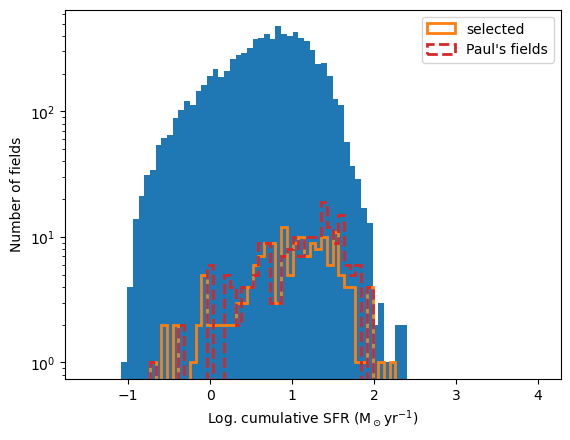

In [36]:
plt.figure()

plt.hist(np.log10(mstar[mstar>0]),bins=np.linspace(8,13,50))
plt.hist(np.log10(mstar[ind]),bins=np.linspace(8,13,50),histtype='step',label="selected fields",lw=2)
plt.hist(np.log10(mstar[i_orig]),bins=np.linspace(8,13,50),histtype='step',label="Paul's fields",color='C3',ls='--',lw=2)
plt.legend()
plt.ylabel("Number of fields")
plt.xlabel("Log. Cumulative stellar mass $\mathrm{(M_\odot)}$")
plt.gca().set_yscale('log')


plt.figure()
plt.hist(np.log10(sfrs[sfrs>0]),bins=np.linspace(-1.5,4,80))
plt.hist(np.log10(sfrs[ind]),bins=np.linspace(-1.5,4,80),histtype='step',label='selected',lw=2)
plt.hist(np.log10(sfrs[i_orig]),bins=np.linspace(-1.5,4,80),histtype='step',label="Paul's fields",color='C3',ls='--',lw=2)
#plt.axvline(np.log10(sfr_min),color='k',ls=':',label='threshold')
plt.legend()
plt.xlabel("Log. cumulative SFR ($\mathrm{M_\odot yr^{-1}}$)")
plt.ylabel("Number of fields")
plt.gca().set_yscale('log')

In [37]:
frac = np.sum(fields_south['sfrtot'].loc[fields_south['selected']])/np.sum(fields_south['sfrtot'])
print("selection covers %.2f percents of local star formation rate"%(frac*100))

selection covers 4.10 percents of local star formation rate


In [38]:
frac = np.sum(fields_south['ntns'].loc[fields_south['selected']])/np.sum(fields_south['ntns'])
print("selection covers %.2f percents of local transients"%(frac*100))

selection covers 7.03 percents of local transients


In [39]:
print(np.sum(np.logical_and(fields_south['selected'],fields_south['BGLT_orig'])),"fields in common with Paul's selection")

18 fields in common with Paul's selection


New selection ranked by cumulative SFR:

In [461]:
fields_south.reset_index(drop=True,inplace=True)

In [497]:
fields_south.iloc[np.argsort(np.array(fields_south['ntns']))[::-1]].loc[~np.isnan(fields_south['ntns'])]

FieldID         ra       dec      mtot_all  nztf  ntns          mtot  \
9174      9175   93.53712   5.21809  0.000000e+00     0    47  0.000000e+00   
5550      5551   73.82488 -19.96355  1.313624e+12     0     9  9.234589e+11   
9695      9696  195.85902   8.36580  1.834785e+11     0     9  2.111975e+10   
12500    12501  167.52475  28.82588  3.625617e+12     1     8  2.214603e+12   
9221      9222  167.42357   5.21809  1.468037e+12     0     8  6.836763e+11   
...        ...        ...       ...           ...   ...   ...           ...   
6513      6514  209.05829 -13.66814  0.000000e+00     0     0  1.015546e+10   
6514      6515  210.67264 -13.66814  2.597684e+11     0     0  1.922856e+11   
6515      6516  212.28699 -13.66814  0.000000e+00     0     0  0.000000e+00   
6516      6517  213.90134 -13.66814  6.523788e+10     0     0  6.523788e+10   
0            1   25.71428 -89.21307  6.231600e+09     0     0  6.002135e+10   

           sfrtot  ngal           lum  BGLT_orig  selected  
9174     0.000000     0  0.000000e+00      False     False  
5550    22.001009     8  7.268898e-06      False     False  
9695     1.406048     2  4.528992e-07      False     False  
12500  166.527145    78  2.311190e-05      False      True  
9221    45.758419    23  1.134865e-05      False      True  
...           ...   ...           ...        ...       ...  
6513     0.976839     1  4.405549e-07      False     False  
6514     1.531088     4  1.343324e-06      False     False  
6515     0.000000     0  0.000000e+00      False     False  
6516     4.130475     1  3.162278e-06      False     False  
0        3.177305     2  2.259436e-06      False     False  

[12742 rows x 12 columns]

In [516]:
np.sum(np.logical_or(mstar>=1e12,ngal>=16))

182

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        73., 62., 34., 22., 15., 16.,  8.,  8.,  4.,  0.,  1.,  2.,  0.]),
 array([0.        , 0.04487179, 0.08974359, 0.13461538, 0.17948718,
        0.22435897, 0.26923077, 0.31410256, 0.35897436, 0.40384615,
        0.44871795, 0.49358974, 0.53846154, 0.58333333, 0.62820513,
        0.67307692, 0.71794872, 0.76282051, 0.80769231, 0.8525641 ,
        0.8974359 , 0.94230769, 0.98717949, 1.03205128, 1.07692308,
        1.12179487, 1.16666667, 1.21153846, 1.25641026, 1.30128205,
        1.34615385, 1.39102564, 1.43589744, 1.48076923, 1.52564103,
        1.57051282, 1.61538462, 1.66025641, 1.70512821, 1.75      ]),
 <BarContainer object of 39 artists>)

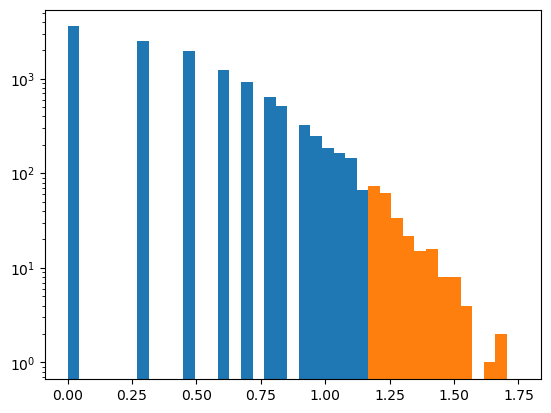

In [483]:
plt.hist(np.log10(fields_south['ngal']+1),bins=np.linspace(0,1.75,40))
plt.gca().set_yscale('log')
plt.hist(np.log10(fields_south['ngal'][fields_south['ngal']>13]+1),bins=np.linspace(0,1.75,40))


Old selection (ranked by cumulative stellar mass):

In [238]:
fields_south.iloc[np.argsort(fields_south['mtot_all'])[::-1]]

FieldID         ra       dec      mtot_all          mtot     sfrtot  \
5231      5232  257.26416 -23.11126  4.409046e+12  1.397756e+11   1.556701   
1363      1364  197.28001 -57.73602  3.695467e+12  0.000000e+00   0.000000   
12311    12312  194.04878  27.25203  3.665175e+12  3.520689e+11  11.173366   
9394      9395   78.94737   6.79195  3.512461e+12  7.325705e+11  33.623124   
16039    16100  243.88667 -60.90834  3.458319e+12  0.000000e+00   0.000000   
...        ...        ...       ...           ...           ...        ...   
6088      6089  239.72726 -16.81585  0.000000e+00  0.000000e+00   0.000000   
6081      6082  228.27272 -16.81585  0.000000e+00  0.000000e+00   0.000000   
6057      6058  189.00000 -16.81585  0.000000e+00  0.000000e+00   0.000000   
1530      1531  304.61539 -56.16217  0.000000e+00  0.000000e+00   0.000000   
1270      1271  285.00000 -59.30987  0.000000e+00  1.694356e+10   1.838276   

       ngal  BGLT_orig  selected  
5231      1       True     False  
1363      0      False     False  
12311    46       True     False  
9394     24       True      True  
16039     0       True     False  
...     ...        ...       ...  
6088      0      False     False  
6081      0      False     False  
6057      0      False     False  
1530      0      False     False  
1270      1      False     False  

[12742 rows x 9 columns]

Image of field with maximum sfr_tot:

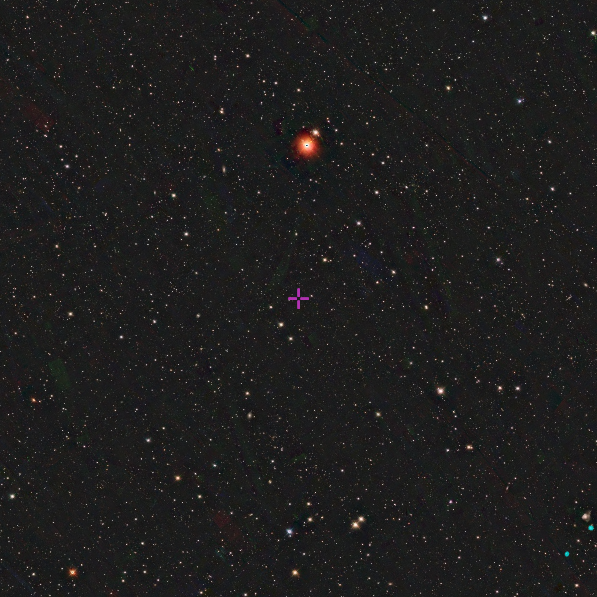

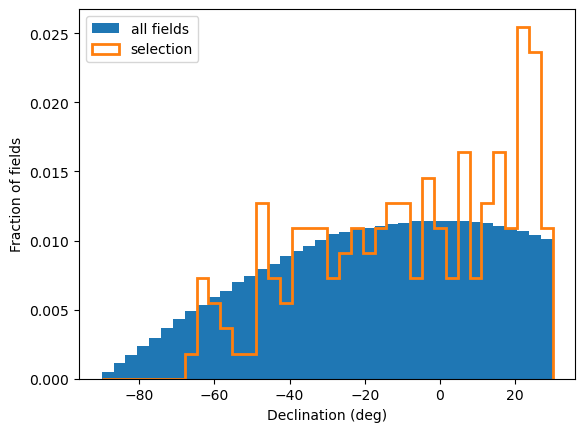

In [101]:
plt.hist(fields_south['dec'],bins=np.linspace(-90,30,39),density=True,label="all fields")
plt.hist(fields_south['dec'].loc[fields_south['selected']],bins=np.linspace(-90,30,39),histtype='step',lw=2,density=True,label="selection")
plt.ylabel("Fraction of fields")
plt.xlabel("Declination (deg)")
plt.legend()

## Get the images of the field of your choice and its galaxies

Retrieve a DSS image of the field and overlay approximate galaxy positions with circles.

https://archive.stsci.edu/cgi-bin/dss_search?v=poss2ukstu_red&r=68.60986&d=-13.66814&e=J2000&h=100&w=100&f=gif
retrieved url
loaded image
(5952, 5941)
PGC075247 68.909126 -13.223139 1927.0273175537454 1364.6264825241337
PGC093410 68.383707 -13.255021 3768.6995197737647 1479.904734634891
PGC093392 68.28678 -13.043157 4108.455391657699 715.2839792054201
ABELL0496:[DFL99]280 68.410737 -13.263754 3673.9551641813378 1511.4883712395108
ABELL0496:[DFL99]356 68.66256 -13.645172 2791.280321765483 2887.628108196142
ABELL0496:[DFL99]265 68.399137 -13.425648 3714.610918596923 2095.4479980572423
PGC075246 68.789333 -12.99255 2346.911583898741 533.2373303611375
PGC075211 68.322125 -12.983444 3984.568668016308 500.03599107435
PGC093405 68.36625 -13.4646 3829.8832476469975 2235.8509425153943
PGC015497 68.241063 -13.204792 4268.690304124327 1298.116117743312
PGC093421 68.428436 -13.146458 3611.9211064165124 1088.4187845823906
PGC015577 68.786125 -13.310097 2358.1665543618356 1678.7205329104597
PGC07522

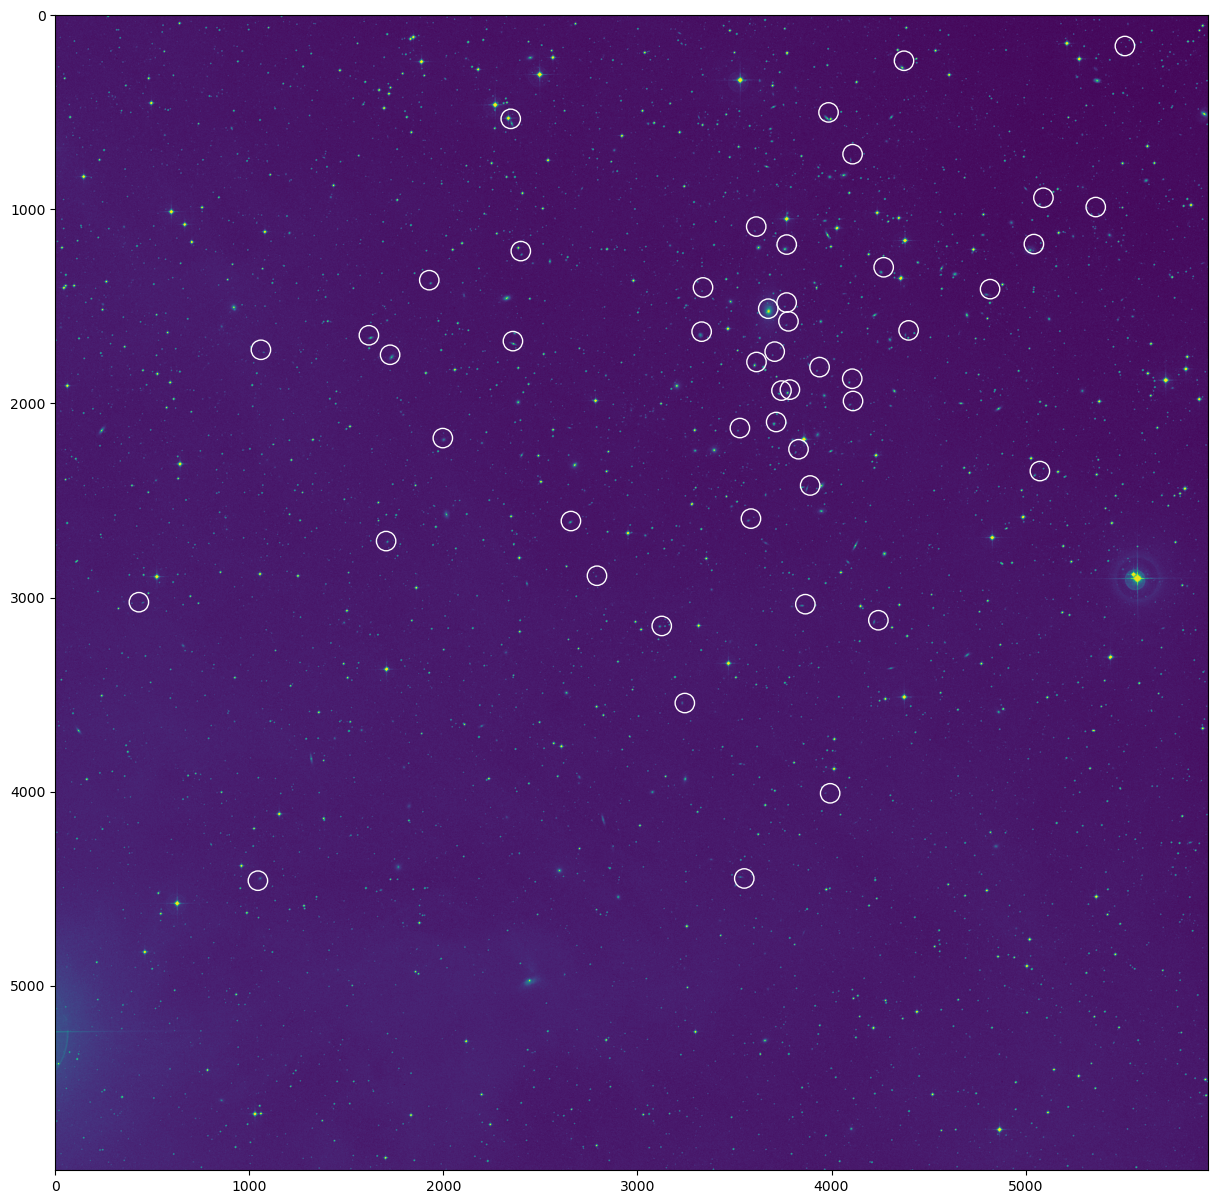

In [468]:

fieldid = 6427 #2607 #16013 #8663  #12312
fieldid = str(fieldid)

raf, decf = np.asarray(fields.loc[fields['FieldID']==int(fieldid),['ra','dec']])[0]
coof = SkyCoord(raf,decf,unit='deg',frame='icrs')


url = 'https://archive.stsci.edu/cgi-bin/dss_search?v=poss2ukstu_red&r=%s&d=%s&e=J2000&h=100&w=100&f=gif'%(raf,decf)
print(url)
cutout = requests.get(url, stream = True)
    
if cutout.status_code == 200:
    print("retrieved url")
    img = np.array(Image.open(cutout.raw))
    print("loaded image")
    print(img.shape)


fig, ax = plt.subplots(1, figsize=(15, 15))
ax.imshow(img)

gals = lvs[np.array(galids[fieldid]),]

scale = img.shape[0]/1.65 # pix per deg



#transients = tns[]


for gal in gals:
    ra, dec = gal['ra'], gal['dec']
    sep = SkyCoord(ra,dec,unit='deg',frame='icrs').separation(coof).deg
    pa = SkyCoord(ra,dec,unit='deg',frame='icrs').position_angle(coof).rad
    
    x = img.shape[0]/2+sep*scale*np.sin(pa)
    y = img.shape[1]/2+sep*scale*np.cos(pa)
    
    circ = Circle((x,y),50,ec="w",fc="None")
    ax.add_patch(circ)
    print(gal['objname'],ra,dec,x,y)
    

    

Display images of galaxies in field

NGC5236
PGC716589
ESO444-086
ESO444-077


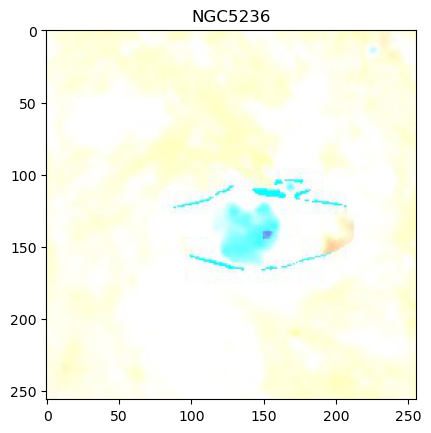

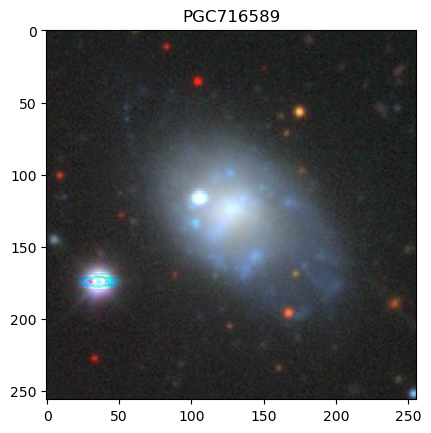

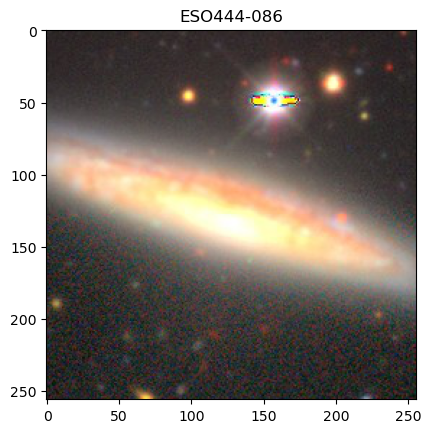

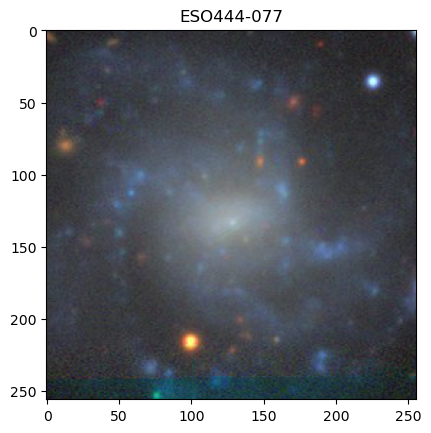

In [466]:

gals = lvs[np.array(galids[fieldid]),]

for gal in gals:
    print(gal['objname'])
    ra, dec = gal['ra'], gal['dec']
    b = SkyCoord(ra,dec,unit='deg',frame='icrs').galactic.b.deg
    if dec>30 or abs(b)<20:
        print("galaxy not in Legacy Survey footprint")
        url = 'https://archive.stsci.edu/cgi-bin/dss_search?v=dss1&r=%s&d=%s&e=J2000&h=1&w=1&f=gif'%(ra,dec)
    else:
        url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra=%s&dec=%s&layer=ls-dr10-grz&zoom=14'%(ra,dec)
    
    cutout = requests.get(url, stream = True)
    
    if cutout.status_code == 200:
        plt.figure()
        img = np.array(Image.open(cutout.raw))
        plt.title(gal['objname'])
        plt.imshow(img)

IC 1124
UGC 09916
WISEA J152838.29+232959.1
EASTERN NUCLEUS


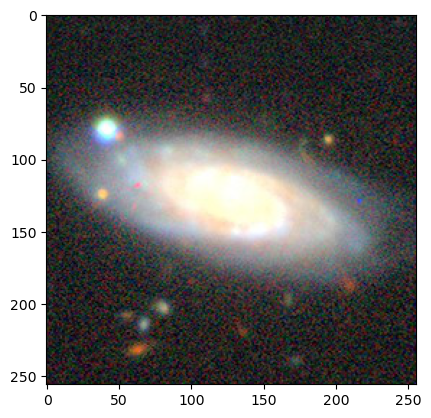

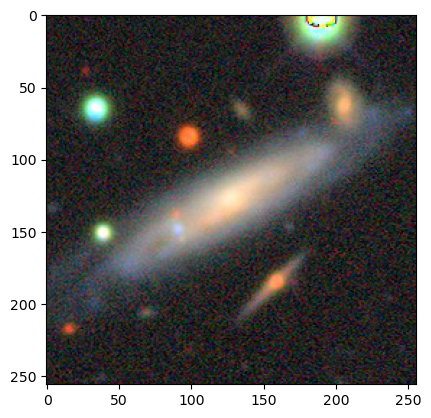

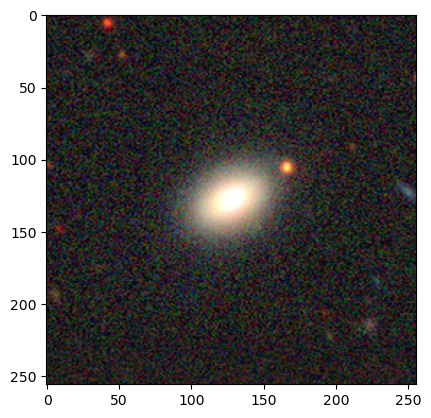

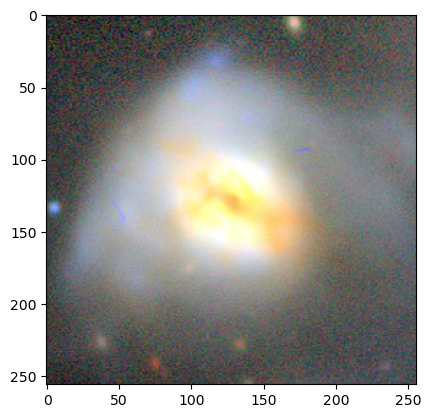

In [122]:
# display images of galaxies in field
fieldid = "11919"

gals = lvs[np.array(galids[fieldid]),]

for gal in gals:
    print(gal['objname'])
    ra, dec = gal['ra'], gal['dec']
    b = SkyCoord(ra,dec,unit='deg',frame='icrs').galactic.b.deg
    if dec>30 or abs(b)<20:
        print("galaxy not in Legacy Survey footprint")
        url = 'https://archive.stsci.edu/cgi-bin/dss_search?v=poss2ukstu_red&r=%s&d=%s&e=J2000&h=1&w=1&f=gif'%(ra,dec)
    else:
        url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra=%s&dec=%s&layer=ls-dr10-grz&zoom=14'%(ra,dec)
    
    cutout = requests.get(url, stream = True)
    
    if cutout.status_code == 200:
        plt.figure()
        img = np.array(Image.open(urllib.request.urlopen(url)))
        plt.imshow(img)

In [256]:
lvs[(lvs['ra']-78.9473700)**2+(lvs['dec']-6.791950)**2<1]['sSFR']

<MaskedColumn name='sSFR' dtype='float64' length=25>
 4.914061089700497e-11
4.2659303506629846e-11
  3.53159801714564e-11
 4.942955305140754e-11
 4.647829428791336e-11
 4.212632850915167e-11
 1.306644914688618e-11
 4.791192960877832e-11
1.2142846030477716e-11
2.6564602924799574e-11
 4.190255038889915e-11
 6.323297101857187e-11
1.3934060721137536e-10
 3.853292971297415e-11
1.5126586392709584e-10
2.0550391483860274e-11
 3.664334080451096e-11
 6.680256037558753e-11
  2.01818248496235e-11
2.3934269890344325e-11
2.6815872584143606e-11
 4.511250228597913e-11
 1.471688186560271e-10
 2.234927954891678e-10
1.1492974455487436e-10

In [290]:
fields.loc[(fields['ra']-330)**2+(fields['dec']+19)**2<3]

FieldID         ra       dec      mtot_all  nztf          mtot  \
5704     5705  329.30878 -19.96355  0.000000e+00   2.0  0.000000e+00   
5705     5706  330.96774 -19.96355  1.573614e+11   2.0  5.513737e+10   
5923     5924  328.76712 -18.38970  0.000000e+00   2.0  0.000000e+00   
5924     5925  330.41098 -18.38970  1.315520e+11   4.0  3.945073e+10   

        sfrtot  ngal  BGLT_orig          sSFR  
5704  0.000000     0      False           NaN  
5705  2.162316     3      False  3.921689e-11  
5923  0.000000     0      False           NaN  
5924  2.120323     2      False  5.374610e-11

In [312]:
fields.loc[fields['FieldID']==9715]

FieldID         ra     dec      mtot_all  nztf          mtot    sfrtot  \
9714     9715  225.99118  8.3658  1.832556e+11     6  1.662210e+11  6.913788   

      ngal  BGLT_orig          sSFR     w1lum  ntns  
9714    10      False  4.159395e-11  0.000131     5

In [280]:
fields['sSFR'] = fields['sfrtot']/fields['mtot']

In [313]:
fields.iloc[np.argsort(np.asarray(fields['ngal']))[::-1]]

FieldID         ra       dec      mtot_all  nztf          mtot  \
13875    13876  247.75281  39.84285  4.441107e+12     5  1.320518e+12   
2606      2607    8.57143 -43.57134  1.102549e+12     0  3.391273e+11   
12311    12312  194.04878  27.25203  3.665175e+12     2  3.520689e+11   
13874    13875  245.73033  39.84285  1.941542e+12     0  6.065311e+11   
7764      7765   36.94323  -4.22502  4.241931e+11     4  1.516800e+11   
...        ...        ...       ...           ...   ...           ...   
8263      8264  101.39738  -1.07732  6.838492e+10     0  0.000000e+00   
8264      8265  102.96943  -1.07732  4.957390e+10     0  0.000000e+00   
8265      8266  104.54148  -1.07732  1.394772e+10     0  0.000000e+00   
8266      8267  106.11353  -1.07732  3.428490e+10     0  0.000000e+00   
8039      8040  108.47161  -2.65117  0.000000e+00     0  0.000000e+00   

          sfrtot  ngal  BGLT_orig          sSFR     w1lum  ntns  
13875  44.301639    87      False  3.354867e-11  0.000702     8  
2606    6.244492    62      False  1.841342e-11  0.000302     1  
12311  11.173366    46       True  3.173631e-11  0.000372     7  
13874  29.430475    37      False  4.852261e-11  0.000325     5  
7764    3.265822    36      False  2.153100e-11  0.000136     2  
...          ...   ...        ...           ...       ...   ...  
8263    0.000000     0      False           NaN  0.000000     0  
8264    0.000000     0      False           NaN  0.000000     0  
8265    0.000000     0      False           NaN  0.000000     0  
8266    0.000000     0      False           NaN  0.000000     0  
8039    0.000000     0      False           NaN  0.000000     2  

[16080 rows x 12 columns]

In [257]:
lvs[np.argsort(lvs['SFR_hybrid'])[::-1]]['sSFR']

<MaskedColumn name='sSFR' dtype='float64' length=31369>
1.2647641342133647e-09
2.2151561617064495e-09
 1.018935734469339e-09
 8.703788516619711e-10
2.0188206742279868e-10
1.5823078288809583e-10
1.0947114512687566e-09
 5.142783763254789e-10
 1.742083729355765e-09
 8.088467337693346e-10
  9.60386885472668e-10
 8.856563890562389e-10
                   ...
1.2268632917866215e-11
1.2655084236837355e-11
1.1519916396131893e-11
1.1545839019517595e-11
1.0733919776204454e-11
1.0486877594910952e-11
1.2040130047908052e-11
1.0322706500040417e-11
1.1280599898344166e-11
 1.088883365129882e-11
1.0830389323506773e-11
1.0050436838430374e-11